# Chapter 6: Multiple Linear Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [87]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline


## Table 6.3

In [88]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis

# Look at all rows
car_df = dmba.load_data('ToyotaCorolla.csv')
# car_df = car_df.iloc[0:1000]

len(car_df)

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

# # partition data
# X = pd.get_dummies(car_df[predictors], drop_first=True)
# y = car_df[outcome]
# train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.5, random_state=1)

# Goal is 50% training, 30% validation, and 20% testing

# Split data into training+validation (80%) and test (20%) 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Further split training+validation into training (50%) and validation (30%)
train_X, X_val, train_y, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=1)


car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

intercept  -7869.889225669645
           Predictor  coefficient
0          Age_08_04  -119.714145
1                 KM    -0.016237
2                 HP    45.042511
3          Met_Color   105.322356
4          Automatic   188.336347
5                 CC    -2.920132
6              Doors   -53.541689
7      Quarterly_Tax    14.801914
8             Weight    20.523371
9   Fuel_Type_Diesel  2820.336747
10  Fuel_Type_Petrol  3327.711813

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1245.8590
            Mean Absolute Error (MAE) : 927.4987
          Mean Percentage Error (MPE) : -1.0258
Mean Absolute Percentage Error (MAPE) : 9.1158


In [89]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8702792238492556
AIC :  12281.708294243572
BIC :  12341.184280171366


## Table 6.4

In [90]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

         Predicted  Actual     Residual
509   12210.523967   10900 -1310.523967
435   11152.788647   10895  -257.788647
321   14000.072852   10750 -3250.072852
1055   6531.332274    6500   -31.332274
288   12603.913351   11895  -708.913351
48    18415.822754   17950  -465.822754
1403   7616.493257    7000  -616.493257
952    9859.374734    8400 -1459.374734
1097   7230.882249    7250    19.117751
204   11874.205697   12950  1075.794303
978    9627.384272    8745  -882.384272
404    9814.371934    9450  -364.371934
1338   7647.663857    7499  -148.663857
754    9148.850298    9950   801.149702
1189   6831.289915    8500  1668.710085
948    8226.103050    7750  -476.103050
1079   6132.201801    8950  2817.798199
1108   7463.991192    8250   786.008808
107   17319.817873   17450   130.182127
1065   5914.638022    6550   635.361978

Regression statistics

                      Mean Error (ME) : 137.0538
       Root Mean Squared Error (RMSE) : 2164.8330
            Mean Absolute Error (MAE)

## Figure 6.1
Determine the residuals and create a histogram

0.7547826086956522


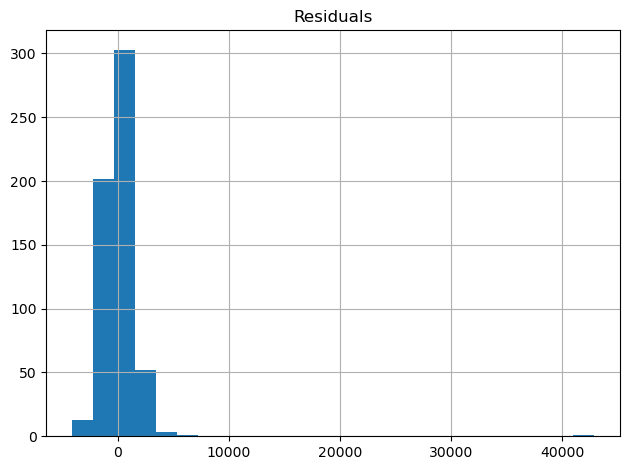

In [91]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

## Table 6.5
Run an exhaustive search. The Fuel type column is categorical and needs to be converted into dummy variables.

In [92]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Automatic     CC  Doors  Fuel_Type_Diesel  \
0    1  0.764703  12698.754601       True      False  False  False             False   
1    2  0.803085  12572.071911       True      False  False  False             False   
2    3  0.840226  12423.202708       True      False  False  False             False   
3    4  0.856161  12348.866723       True      False  False  False             False   
4    5  0.864772  12305.594724       True      False  False  False             False   
5    6  0.867273  12293.200180       True      False  False  False             False   
6    7  0.867752  12291.599884       True      False  False   True             False   
7    8  0.870299  12278.641061       True      False   True  False              True   
8    9  0.870315  12279.539135       True       True   True  False              True   
9   10  0.870307  12280.572340       True      False   True   True              True   
10  11  0.870279  12281.708294  

## Table 6.6 backward elimination

In [93]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=12281.71
Step: score=12280.57, remove Automatic
Step: score=12279.66, remove Met_Color
Step: score=12278.64, remove Doors
Step: score=12278.64, remove None
['Age_08_04', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


In [94]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : 134.8332
       Root Mean Squared Error (RMSE) : 2216.6591
            Mean Absolute Error (MAE) : 1024.2540
          Mean Percentage Error (MPE) : -0.0543
Mean Absolute Percentage Error (MAPE) : 9.9140


## Table 6.7 Forward selection

In [95]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=13735.19, constant
Step: score=12698.75, add Age_08_04
Step: score=12572.07, add HP
Step: score=12479.82, add Weight
Step: score=12349.53, add KM
Step: score=12330.03, add Fuel_Type_Petrol
Step: score=12293.20, add Quarterly_Tax
Step: score=12291.60, add Doors
Step: score=12291.26, add CC
Step: score=12279.66, add Fuel_Type_Diesel
Step: score=12279.66, add None
['Age_08_04', 'HP', 'Weight', 'KM', 'Fuel_Type_Petrol', 'Quarterly_Tax', 'Doors', 'CC', 'Fuel_Type_Diesel']


In [96]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=13735.19, constant
Step: score=12698.75, add Age_08_04
Step: score=12572.07, add HP
Step: score=12479.82, add Weight
Step: score=12349.53, add KM
Step: score=12330.03, add Fuel_Type_Petrol
Step: score=12293.20, add Quarterly_Tax
Step: score=12291.60, add Doors
Step: score=12291.26, add CC
Step: score=12279.66, add Fuel_Type_Diesel
Step: score=12278.64, remove Doors
Step: score=12278.64, unchanged None
['Age_08_04', 'HP', 'Weight', 'KM', 'Fuel_Type_Petrol', 'Quarterly_Tax', 'CC', 'Fuel_Type_Diesel']


## Table XX regularized methods

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lasso = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Lasso(alpha=1)],
])
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LassoCV(cv=5)],
])
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv['model'].alpha_)
print(lasso_cv['model'].coef_)

ridge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Ridge(alpha=1)],
])
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', BayesianRidge()],
])
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', 
      bayesianRidge['model'].lambda_ / bayesianRidge['model'].alpha_)


Regression statistics

                      Mean Error (ME) : 133.7239
       Root Mean Squared Error (RMSE) : 2103.1028
            Mean Absolute Error (MAE) : 1015.8762
          Mean Percentage Error (MPE) : -0.0307
Mean Absolute Percentage Error (MAPE) : 9.8659

Regression statistics

                      Mean Error (ME) : 126.5551
       Root Mean Squared Error (RMSE) : 1973.1077
            Mean Absolute Error (MAE) : 1009.2096
          Mean Percentage Error (MPE) : -0.0837
Mean Absolute Percentage Error (MAPE) : 9.8313
Lasso-CV chosen regularization:  3.0490587368991493
[-2175.34543726  -607.48378823   608.95747698    44.73342846
    39.38326269  -473.46824471   -51.95274814   559.32968783
   991.0046799    707.74262378   985.66514738]

Regression statistics

                      Mean Error (ME) : 134.0573
       Root Mean Squared Error (RMSE) : 2107.6737
            Mean Absolute Error (MAE) : 1015.9482
          Mean Percentage Error (MPE) : -0.0322
Mean Absolute Percenta

In [98]:
linearRegression = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LinearRegression()],
])
linearRegression.fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 137.0538
       Root Mean Squared Error (RMSE) : 2164.8330
            Mean Absolute Error (MAE) : 1019.3439
          Mean Percentage Error (MPE) : -0.0058
Mean Absolute Percentage Error (MAPE) : 9.8872


In [99]:
pd.DataFrame({
    'features': train_X.columns, 
    'linear regression': linearRegression['model'].coef_, 
    'lassoCV': lasso_cv['model'].coef_, 
    'bayesianRidge': bayesianRidge['model'].coef_,
})

,features,linear regression,lassoCV,bayesianRidge
0,Age_08_04,-2172.700156,-2175.345437,-2166.839479
1,KM,-606.988690,-607.483788,-612.217691
2,HP,667.859073,608.957477,635.578106
3,Met_Color,49.597255,44.733428,48.749688
4,Automatic,45.201085,39.383263,42.654153
5,CC,-547.371728,-473.468245,-506.538657
6,Doors,-51.017456,-51.952748,-52.843116
7,Quarterly_Tax,575.439930,559.329688,564.860603
8,Weight,985.431058,991.004680,990.153192
9,Fuel_Type_Diesel,847.672152,707.742624,757.437172


## Table 6.10

In [100]:
*# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     437.7
Date:                Wed, 22 May 2024   Prob (F-statistic):          2.87e-306
Time:                        21:19:01   Log-Likelihood:                -6127.9
No. Observations:                 717   AIC:                         1.228e+04
Df Residuals:                     705   BIC:                         1.233e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# Solution for Toyota Analysis Questions

# Activity:

The file ToyotaCorolla.csv contains data on used cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has 1436 records containing details on 38 attributes, including Price, Age, Kilometers, HP, and other specifications. The goal is to predict the price of a used Toyota Corolla based on its specifications.

Split the data into training (50%), validation (30%), and test (20%) datasets.

Run a multiple linear regression with the outcome variable Price and predictor variables Age_08_04, KM, Fuel_Type, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, and Tow_Bar.

# Methodology:
* Instead of taking only the first 1,000 rows of data, remove the line above so all rows are factored in.
* Leverage the split solution of train/test/validation from here: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn 

Go to Table 6.3 to see my solution for this.

__What appear to be the three or four most important car specifications for predicting the car’s price?__

Based on the OLS Regression Results, and the p-value analysis, anything that has a p-value lower than 0.05 is statistically significant.
This is assuming an alpha of 0.05.

Basically, every feature EXCEPT Met_color, Automatic and Doors has a p-value higher than 0.05, everything else is a good indicator and is statistically significant.

Ignoring Intercept, the following have high coefficients:
* Fuel_Type_Diesel[T.True] 
* Fuel_Type_Petrol[T.True]
* Met_Color 
* Automatic

__Using metrics you consider useful, assess the performance of the model in predicting prices__